In [1]:
from utils_luke import to_standard_units, formatter, rodrigues
import os
os.chdir("../")
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from godot.core import tempo, astro, events
from godot.core.autodif import bridge as br
from godot import cosmos
from godot.model import eventgen, common, prop
import godot.core.util as util
util.suppressLogger()

In [2]:
f=open("HaloOrbit/GateWayOrbit_prop.csv","r")
lines=f.readlines()
print(lines[0])
lines = lines[1:]
f.close()
lines = [[float(element) for element in line.strip().split(",")] for line in lines]
#change to seconds and km
HaloData = np.array([[to_standard_units(line[0], "TU"), to_standard_units(line[1], "LU"), to_standard_units(line[2], "LU"), to_standard_units(line[3], "LU")] for line in lines])

Time (TU),X (LU),Y (LU),Z (LU),VX (LU/TU),VY (LU/TU),VZ (LU/TU)



3038.3139873756445


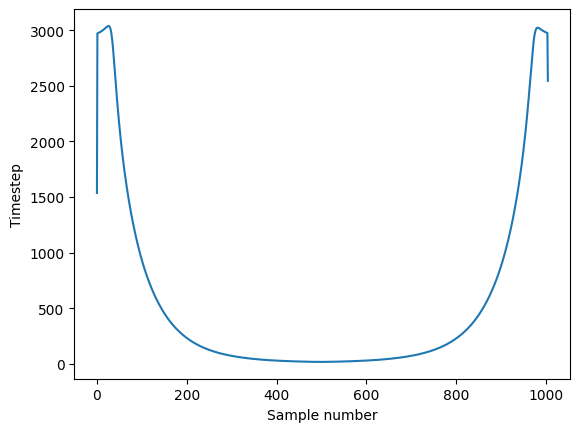

In [3]:
time_val=HaloData.T[0]
time_step=np.zeros(len(time_val)-1)
for i in range(len(time_step)):
    time_step[i]=time_val[i+1]-time_val[i]
print(max(time_step))

plt.plot(time_step)
plt.xlabel("Sample number")
plt.ylabel("Timestep")
plt.savefig("HaloOrbit/HaloOrbitDataTimestep.png")

In [4]:
uni_config=cosmos.util.load_yaml("universe2.yml")
uni = cosmos.Universe(uni_config)

ep1 = tempo.Epoch('2026-01-01T00:00:00 TT')
ep2 = tempo.Epoch('2026-04-01T00:00:00 TT')
ran = tempo.EpochRange( ep1, ep2 )
timestep=30.0
grid = ran.createGrid(timestep) # 60 seconds stepsize
eps = 1e-6
tol = 1e-6
print(len(grid))
print(ep2-ep1)
print(ep1-ep2)

259201
7776000.0
-7776000.0


In [5]:
uni_config=cosmos.util.load_yaml("universe2.yml")
uni = cosmos.Universe(uni_config)
frames = uni.frames
icrf = frames.axesId('ICRF')
moonPoint=frames.pointId('Moon')
earthPoint=frames.pointId('Earth')

moonData=np.asarray([frames.vector3(earthPoint, moonPoint, icrf, ep) for ep in grid])


move initial halo data to position on moon orbit

In [6]:
def rotation(point, axis, angle):
    v1=point*np.cos(angle)
    v2=np.cross(axis, point)*np.sin(angle)
    v3=axis*np.dot(axis, point)*(1-np.cos(angle))
    return v1+v2+v3

In [7]:
def rotation_matrix(moonPos, x_moon):
        # determine rotation matrix
        rot_axis= np.cross(moonPos, x_moon)
        rot_axis = rot_axis/np.linalg.norm(rot_axis)
        angle = -np.arccos(np.dot(x_moon, moonPos)/(np.linalg.norm(x_moon)*np.linalg.norm(moonPos)))
        R=np.array([[rot_axis[0]**2*(1-np.cos(angle))+np.cos(angle),                        rot_axis[0]*rot_axis[1]*(1-np.cos(angle))-rot_axis[2]*np.sin(angle),    rot_axis[0]*rot_axis[2]*(1-np.cos(angle))+rot_axis[1]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[1]*(1-np.cos(angle))+rot_axis[2]*np.sin(angle),   rot_axis[1]**2*(1-np.cos(angle))+np.cos(angle),                         rot_axis[1]*rot_axis[2]*(1-np.cos(angle))-rot_axis[0]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[2]*(1-np.cos(angle))-rot_axis[1]*np.sin(angle),   rot_axis[1]*rot_axis[2]*(1-np.cos(angle))+rot_axis[0]*np.sin(angle),    rot_axis[2]**2*(1-np.cos(angle))+np.cos(angle)]])
        return R

In [8]:
def rotation_matrix_1(rot_axis, angle):
        # determine rotation matrix
        # rot_axis= np.cross(moonPos, x_moon)
        # rot_axis = rot_axis/np.linalg.norm(rot_axis)
        # angle = -np.arccos(np.dot(x_moon, moonPos)/(np.linalg.norm(x_moon)*np.linalg.norm(moonPos)))
        rot_axis/=np.linalg.norm(rot_axis)
        R=np.array([[rot_axis[0]**2*(1-np.cos(angle))+np.cos(angle),                        rot_axis[0]*rot_axis[1]*(1-np.cos(angle))-rot_axis[2]*np.sin(angle),    rot_axis[0]*rot_axis[2]*(1-np.cos(angle))+rot_axis[1]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[1]*(1-np.cos(angle))+rot_axis[2]*np.sin(angle),   rot_axis[1]**2*(1-np.cos(angle))+np.cos(angle),                         rot_axis[1]*rot_axis[2]*(1-np.cos(angle))-rot_axis[0]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[2]*(1-np.cos(angle))-rot_axis[1]*np.sin(angle),   rot_axis[1]*rot_axis[2]*(1-np.cos(angle))+rot_axis[0]*np.sin(angle),    rot_axis[2]**2*(1-np.cos(angle))+np.cos(angle)]])
        return R

Find lunar orbit plane

In [9]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(moonData)
rot_axis=pca.components_[2]
rot_axis /= np.linalg.norm(rot_axis)
print(pca.singular_values_)

[1.40338845e+08 1.35603575e+08 1.79469529e+05]


get initial point and project to lunar orbit plane

In [10]:
x_moon=np.array([to_standard_units(1, "LU"), 0, 0])
# x_moon=np.array([1, 0, 0])
moon_index=np.argmin([np.linalg.norm(moonPos-x_moon) for moonPos in moonData])
init_moonPoint=moonData[moon_index]
print(moonData[moon_index])
#project to plane
Proj=np.eye(3)-np.outer(rot_axis,rot_axis)
init_moonPoint=Proj@init_moonPoint

[379577.45405264  -6151.77417433  10685.98047357]


move halo orbit to be initially on lunar orbit plane

In [11]:
init_axis=np.cross(init_moonPoint, x_moon)
init_angle=np.dot(x_moon, init_moonPoint)/(np.linalg.norm(init_moonPoint)*np.linalg.norm(x_moon))
init_angle=np.arccos(init_angle)
print(init_angle)
moon_len=np.linalg.norm(init_moonPoint)

0.032878899108404316


In [12]:
from mpl_toolkits.mplot3d import Axes3D

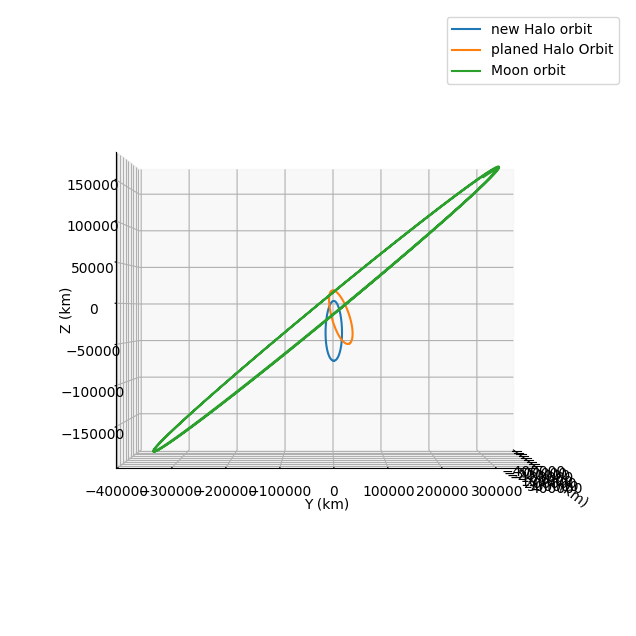

In [13]:
xy_plane=np.array([0,0,1])
#rot_axis
plane_axis=np.cross(xy_plane, rot_axis)
plane_angle=np.dot(xy_plane, rot_axis)/(np.linalg.norm(xy_plane)*np.linalg.norm(rot_axis))
plane_angle=np.arccos(plane_angle)

new_HaloData=np.zeros((len(HaloData), 3))
Rot_mat=rotation_matrix_1(plane_axis, plane_angle)
intermediate_moon_point=x_moon @ Rot_mat
for i, HaloPos in enumerate(HaloData):
    pos=Rot_mat@HaloPos[1:]
    new_HaloData[i]=pos

new_HaloData=np.insert(new_HaloData.T, 0, HaloData.T[0], axis=0).T

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*HaloData.T[1:], label="new Halo orbit")
ax.plot(*new_HaloData.T[1:], label='planed Halo Orbit')
ax.plot(*moonData.T, label='Moon orbit')

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
ax.view_init(elev=0, azim=0)
plt.show()

In [14]:
planed_HaloData=np.zeros((len(HaloData), 3))
Rot_mat=rotation_matrix(init_moonPoint, intermediate_moon_point)
for i, HaloPos in enumerate(new_HaloData):
    pos=Rot_mat@HaloPos[1:]
    planed_HaloData[i]=pos

planed_HaloData=np.insert(planed_HaloData.T, 0, HaloData.T[0], axis=0).T

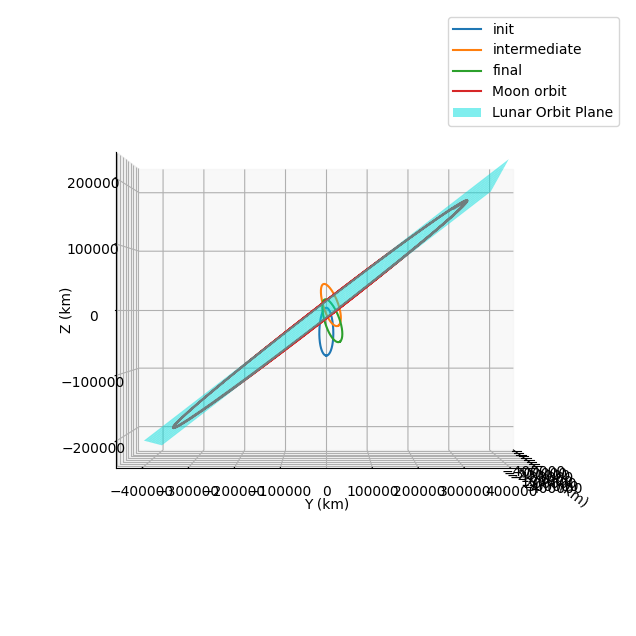

In [25]:
# %matplotlib widget
%matplotlib inline
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*HaloData.T[1:], label="init")
ax.plot(*planed_HaloData.T[1:], label='intermediate')
ax.plot(*new_HaloData.T[1:], label="final")
ax.plot(*moonData.T, label='Moon orbit')

# Plot the plane for rot_axis
xx, yy = np.meshgrid(np.linspace(-400000, 400000, 10), np.linspace(-400000, 400000, 10))
z = (-rot_axis[0] * xx - rot_axis[1] * yy) / rot_axis[2]
ax.plot_surface(xx, yy, z, alpha=0.5, color='cyan', label='Lunar Orbit Plane')
# ax.scatter(to_standard_units(1, "LU"), 0, 0, color="red", s=40, label="x_moon")

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
ax.view_init(elev=0, azim=0)
plt.show()


rotate plane

Create emphimeris

In [16]:
from scipy.linalg import expm
def closest_time(time, orbits, HaloOrbitTime, HaloData):
    tempTime = time - orbits * HaloOrbitTime
    if tempTime < 0:
        raise ValueError("Time is less than 0")
    return np.abs(tempTime-HaloData[:,0]).argmin()

def epoch_to_seconds(epoch, epoch0):
    return epoch - epoch0

def inPlane_rotationmatrix(rot_axis):
    # return np.cross(rot_axis, np.eye(3))
    L=np.array([[0, -rot_axis[2], rot_axis[1]],
                    [rot_axis[2], 0, -rot_axis[0]],
                    [-rot_axis[1], rot_axis[0], 0]])
    return L

def find_angle(init_moonPoint, moonPos, rot_axis):
    # angle=-np.arccos(np.dot(init_moonPoint/np.linalg.norm(init_moonPoint), moonPos/np.linalg.norm(moonPos))/(np.linalg.norm(init_moonPoint)*np.linalg.norm(moonPos)))
    angle=-np.arccos(np.dot(init_moonPoint, moonPos)/(np.linalg.norm(init_moonPoint)*np.linalg.norm(moonPos)))
    sign=np.sign(np.dot(np.cross(init_moonPoint, moonPos), rot_axis)) # possibly remove this
    return sign*angle
    # return angle

def inplane_rotation_matrix(rot_mat, angle, init_point):
    return  np.array(expm(angle*rot_mat)) @ init_point 

def rotation_matrix_new(moonPos, x_moon, rot_axis, angle):
        # determine rotation matrix
        R=np.array([[rot_axis[0]**2*(1-np.cos(angle))+np.cos(angle),                        rot_axis[0]*rot_axis[1]*(1-np.cos(angle))-rot_axis[2]*np.sin(angle),    rot_axis[0]*rot_axis[2]*(1-np.cos(angle))+rot_axis[1]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[1]*(1-np.cos(angle))+rot_axis[2]*np.sin(angle),   rot_axis[1]**2*(1-np.cos(angle))+np.cos(angle),                         rot_axis[1]*rot_axis[2]*(1-np.cos(angle))-rot_axis[0]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[2]*(1-np.cos(angle))-rot_axis[1]*np.sin(angle),   rot_axis[1]*rot_axis[2]*(1-np.cos(angle))+rot_axis[0]*np.sin(angle),    rot_axis[2]**2*(1-np.cos(angle))+np.cos(angle)]])
        return R

In [17]:
emph=np.zeros((len(grid), 3))
projected_moon=np.zeros((len(grid), 3))
epoch0=grid[0]
HaloOrbitTime=planed_HaloData[-1][0]
inAxis_rot_mat=inPlane_rotationmatrix(rot_axis)
for i, ep in enumerate(grid):
    # print(i)
    time=epoch_to_seconds(ep, epoch0)
    orbits=np.floor(time/HaloOrbitTime)
    HaloOrbitPos=np.array(planed_HaloData[closest_time(time, orbits, HaloOrbitTime, planed_HaloData)])
    HaloOrbitPos=HaloOrbitPos[1:]
    HaloOrbitLen = np.linalg.norm(x_moon- HaloOrbitPos)
    
    moonPos=np.array(moonData[i])
    moon_len=np.linalg.norm(moonPos)
    Proj=np.eye(3)-np.outer(rot_axis,rot_axis) #project to plane
    moonPos=Proj@moonPos
    projected_moon[i]=moonPos

    angle=find_angle(init_moonPoint, moonPos, rot_axis)
    # angle=chat_angle(rot_axis, moonPos, init_moonPoint)
    # rotation_mat=inplane_rotation_matrix(inAxis_rot_mat, angle, init_moonPoint)
    rotation_mat=rotation_matrix_new(moonPos, init_moonPoint, rot_axis, angle)
    pos=HaloOrbitPos @ rotation_mat
    emph[i]=(pos/np.linalg.norm(pos))*(moon_len)
    # emph[i]=pos

write emphimeris as txt

In [18]:
# import csv
# filename="haloOrbit_emph.csv"
# with open(filename, "w", newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(emph)
# f.close()

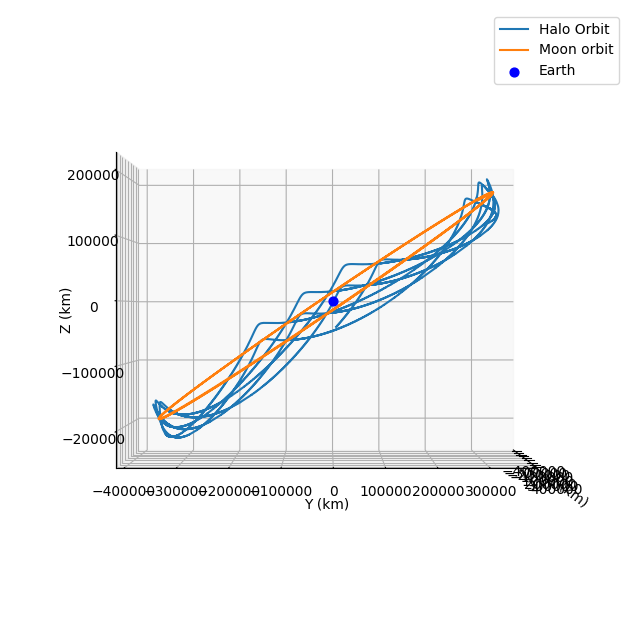

In [19]:
# %matplotlib widget
%matplotlib inline
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*emph.T, label='Halo Orbit')
ax.plot(*moonData.T, label='Moon orbit')
# ax.plot(*projected_moon.T, label='projected moon')
ax.scatter(0,0,0, color="blue", s=40, label="Earth")
# Plot the rotation axis
# ax.quiver(0, 0, 0, rot_axis[0], rot_axis[1], rot_axis[2], color='red', length=100000, label='Rotation Axis')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
ax.view_init(azim=0, elev=0)
fig.savefig("HaloOrbit/MovingHaloOrbit.png", bbox_inches='tight')

plt.show()

In [20]:
res = [np.linalg.norm(moonData[i]-projected_moon[i]) for i in range(len(moonData))]
print(np.max(res))

1029.528589330947


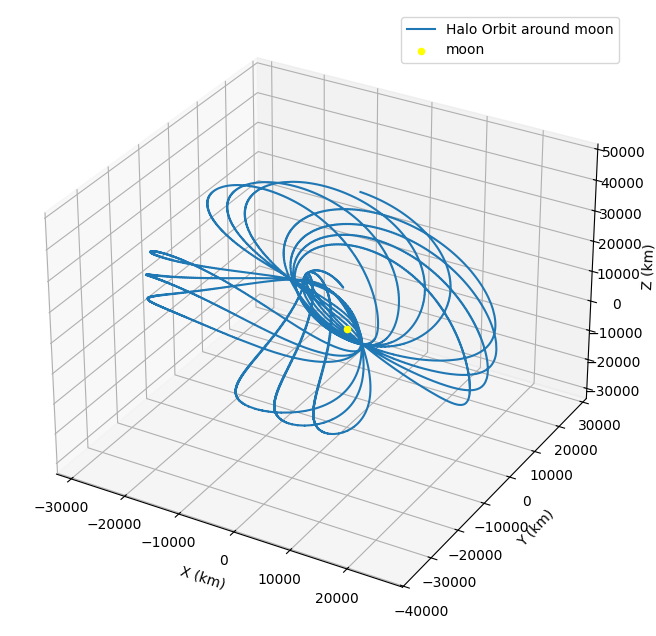

In [21]:
# %matplotlib widget
orbit_moon_centered=moonData-emph

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*orbit_moon_centered.T, label='Halo Orbit around moon')
ax.scatter(0, 0, 0, color="yellow", label="moon")
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()

plt.show()

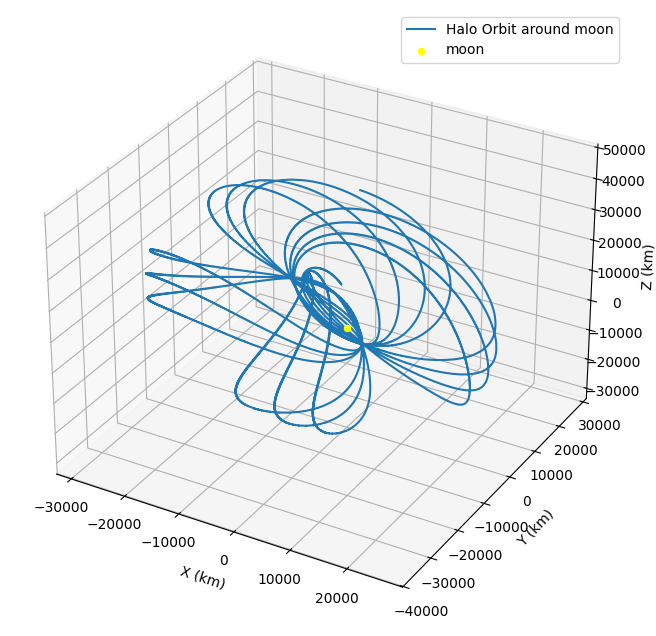

In [22]:
orbit_projMoon_centered=np.zeros((len(moonData), 3))
for i in range(len(moonData)):
    orbit_projMoon_centered[i]=projected_moon[i]-emph[i]
    # print(projected_moon[i]-emph[i])
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*orbit_projMoon_centered.T, label='Halo Orbit around moon')
ax.scatter(0, 0, 0, color="yellow", label="moon")
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()

plt.show()

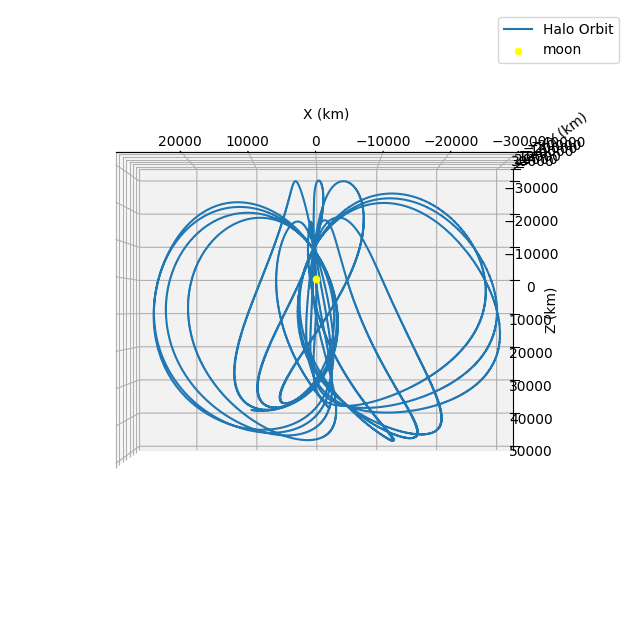

In [30]:
%matplotlib inline
orbit_projMoon_centered=projected_moon-emph

    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*orbit_projMoon_centered.T, label='Halo Orbit')
ax.scatter(0, 0, 0, color="yellow", label="moon")
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
# ax.view_init(elev=200, azim=40)
ax.view_init(elev=180, azim=90)
fig.savefig("HaloOrbit/HaloAroundMoon.png", bbox_inches='tight')

plt.show()

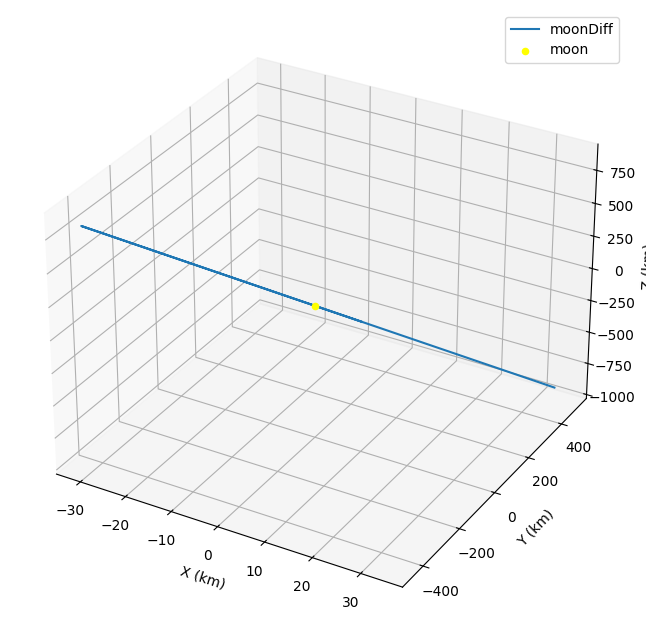

In [24]:
moonDiff=moonData-projected_moon


    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot(*moonDiff.T, label='moonDiff')
ax.scatter(0, 0, 0, color="yellow", label="moon")
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()

plt.show()